# PlanoLux

> This is a library for doing 2D ray tracing.
> There is interest in recreating the Unity Vector Class so that code may be ported.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export
import numpy as np

This is the basic class for 2D points.

In [ ]:
#| export
class Point:
    def __init__(self, xi, yi):
        self.x = xi
        self.y = yi

    def __str__(self):
        return "({a:0.2f},{b:0.2f})".format(a=self.x, b=self.y)

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)

    def __mul__(self, other):
        x = self.x*other
        y = self.y*other
        return Point(x, y)

    def __invert__(self):
        return Point(-x, -y)

    def cross(self, other):
        return self.x * other.y - self.y * other.x

    def dot(self, other):
        return self.x * other.x + self.y * other.y

    def mag(self):
        return np.sqrt(self.x**2 + self.y**2)

    def norm(self):
        m = self.mag()
        x = self.x/m
        y = self.y/m 
        return Point(x, y)

This is the class for a ray, or vector with origin point.

In [ ]:
#| export
class Ray:
    def __init__(self, ai, bi, ii=1.0):
        self.a      = ai
        self.b      = bi
        self.I      = ii
    def vec(self):
        return self.b-self.a  
    def unit_vec(self):
        return (self.b-self.a).norm()
    def __str__(self):
        return "{a} -> {b}".format(a=self.a,b=self.b)

This is a surface to reflect, refract, absorb, scatter, image at.

This needs to be ref/ref, ref only, absorb only, scatter

In [ ]:
#| export
class Surface:
    def __init__(self, ai, bi, n1=1.0, n2=1.5):
        self.n1     = n1                # This is n1/n2
        self.n2     = n2                # This is n1/n2
        self.s      = Ray(ai,bi)

    def vec(self):
        return self.s.vec()  

    def normal(self):                   # CCW Winding
        si = self.vec()
        return Point(si.y, -si.x)  

    def normal_at(self, p):
        return Ray(p, self.normal()+p)  

Intersection and ray casting.

In [ ]:
#| export

def intersect(R,S):
    ac = R.a - S.s.a
    sxr = S.s.vec().cross(R.vec())
    if sxr != 0:
        t = ac.cross(S.vec())/sxr
        u = ac.cross(R.vec())/sxr
        if t > 0 and u > 0 and u < 1:
            return R.vec()*t + R.a
        else:
            return None
    else:
        return None

def cast(r,surf):
    d = np.inf
    pc = None
    sc = None

    # Collide Ray with closest surface
    for s in surf:
        p = intersect(r,s)
        if p != None:
            if ((r.a-p).mag() < d):
                d = (r.a-p).mag()
                pc = p
                sc = s
    return pc, sc

def gen_rays(sp = Point(0,0), ao = -180, ae = 180, na = 60, endpoint = True):
    rays = []

    for tang in np.linspace(ao,ae,na,endpoint=endpoint):
        ang = tang*np.pi/180
        ra = Ray(sp,sp+Point(np.cos(ang), np.sin(ang)))
        rays.append(ra)

    return rays

def plot_scene(rays, surfs, sp, raycol='red'):
    import matplotlib.pyplot as plt
    fig = plt.figure()

    # Plot Rays
    for r in rays:
        #plt.plot([r.a.x, r.b.x], [r.a.y, r.b.y], '-r')
        plt.arrow(r.a.x, r.a.y, r.vec().x, r.vec().y, width=0.0005, color=raycol, length_includes_head=True,head_width=0.03, head_length=0.06)

    # Plot Surface and normals
    for s in surfs:
        plt.plot([s.s.a.x, s.s.b.x], [s.s.a.y, s.s.b.y], '-b')
        mp = (s.s.a+s.s.b)*0.5
        n = Ray(mp, mp+s.normal()*0.25)
        plt.plot([n.a.x, n.b.x], [n.a.y, n.b.y], '-k')

    # Plot Source Point
    plt.plot(sp.x, sp.y, marker='o', markerfacecolor=raycol, linestyle='None')

    plt.axis('equal')
    plt.show(fig)

Now show this works.

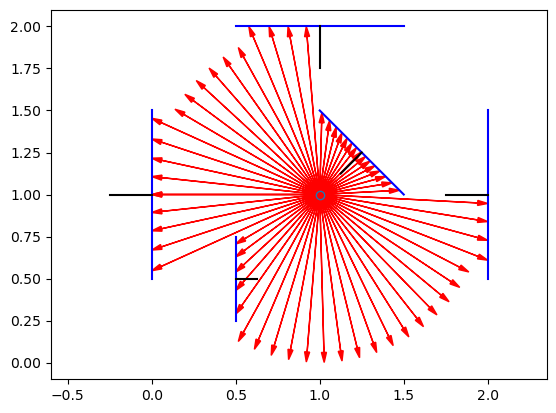

In [ ]:
#| hide
surf = []
surf.append(Surface(Point(1.0,1.5), Point(1.5,1)))
surf.append(Surface(Point(0.5,2), Point(1.5,2)))

surf.append(Surface(Point(2.0,1.5), Point(2.0,0.5)))
surf.append(Surface(Point(0.0,1.5), Point(0.0,0.5)))

surf.append(Surface(Point(0.5,0.25), Point(0.5,0.75)))

# Source Point
sp    = Point(1,1)

# Initial Rays
rays = gen_rays(sp, -180, 180, 60)

for r in rays:
    pc, sc = cast(r,surf)
    if pc != None:
        r.b = pc

plot_scene(rays, surf, sp)

## Vector Reflection
For an incoming ray $\vec{s}$ and a surface normal $\vec{n}$ the reflected ray $\vec{v}_{reflect}$

$$ \vec{v}_{reflect} = \vec{s} - 2 (\vec{s} \cdot \vec{n}) \vec{n}$$

In [ ]:
#| export
def reflect(R,S,P):
    n = S.normal().norm()
    d = R.vec().norm()
    r = d-n*d.dot(n)*2
    off = n*np.sign(r.dot(n))*1e-12
    return Ray(P+off,P+r)

This checked reflections at various angles.

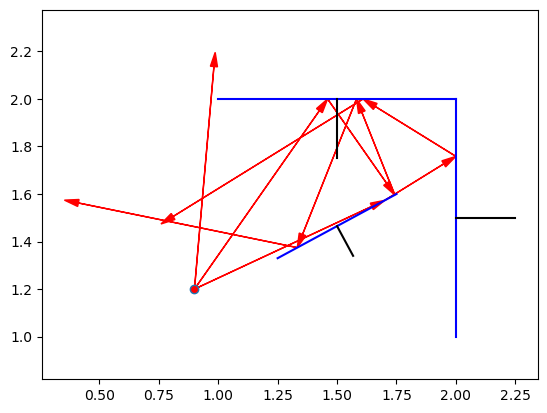

In [ ]:
#| hide
surf = []
surf.append(Surface(Point(2.0,1.0), Point(2.0,2.0)))
surf.append(Surface(Point(1.0,2.0), Point(2.0,2.0)))
surf.append(Surface(Point(1.25,1.33), Point(1.75,1.6)))

# Source Point
sp    = Point(0.90,1.2)

# Initial Rays
rays_out = gen_rays(sp, 25, 85, 3)

rays_all = []

for k in range(5):
    rays_in = rays_out.copy()
    rays_out = []
    for r in rays_in:
        pc, sc = cast(r,surf)
        if pc != None:
            r.b = pc
            ref = reflect(r,sc,pc)
            rays_out.append(ref)
        rays_all.append(r)
        #print('{k}: In {rin} Ref {ref}'.format(k=k, rin=r, ref=ref))
for r in rays_out:
    rays_all.append(r)


plot_scene(rays_all, surf, sp, raycol='red')

## Vector refraction Snell's Law

For an incoming ray $\vec{s}$ and a surface normal $\vec{n}$ the refracted ray $\vec{v}_{refract}$

$$\vec{v}_{refract} = r \vec{s} + \left( r c - \sqrt{1-r^2 (1-c^2)} \vec{n} \right)$$

where $r = \frac{n_1}{n_2}$ and $c = -\vec{n} \cdot \vec{s}$.

In [ ]:
#| export
# r = n1/n2
# c = -ni.di
# f = (rc - sqrt(1-r**2 (1-c**2))
# v = r di + f ni
def refract(R, S, P):
    n = S.normal().norm()
    l = R.vec().norm()
    r = S.n1/S.n2

    side = np.sign(l.dot(n))
    if side > 0:
        n = Point(-n.x,-n.y)
        r = 1/r

    c = -n.dot(l)
    f = r*c - np.sqrt(1-r**2*(1-c**2))
    v = l*r + n*f

    if l.dot(v) > 0:
        off = n*1e-12
        return Ray(P-off, P + v)
    else:
        return None


In [ ]:
#| hide

surf = []
surf.append(Surface(Point(1.0,-1.0), Point(-1.0,-1.0)))
surf.append(Surface(Point(-1.5,-1.5), Point(1.5,-1.5)))

# surf.append(Surface(Point(1.0,1), Point(1.0,-1.0)))
# surf.append(Surface(Point(1.5,-1.5), Point(1.5,1.5)))


N = 16
R1 = 3.0
R2 = R1
T  = 0.5
H  = 0.75

# 1/f = (n2-1)(1/R1+1/r2)-(n2-1)**2*d/(n2*R1*r2)
n = surf[0].n2
fin = (n-1)*(1/R1+1/R2)-((n-1)**2)*T/(n*R1*R2)

XL = -1/fin
print(1/fin)
#print(np.arcsin(surf[0].n1/surf[0].n2)*180.0/np.pi)
#XL = -5


3.085714285714286


In [ ]:
#| export
def lens(R1, R2, T, H, XL, N=16):
    aa =  -np.arcsin(H/R1)
    ab =  -aa

    su = []

    pnts = []
    r = R1
    c1 = Point(XL-R1+T/2,0)
    c2 = Point(XL+R2-T/2,0)
    pnts = [Point(np.cos(sa), np.sin(sa)) for sa in np.linspace(aa, ab, N, endpoint=True)]
    for k in range(len(pnts)-1):
        su.append(Surface((pnts[k]*R1)+c1, (pnts[k+1]*R1)+c1))
        su.append(Surface((pnts[k]*(-R2))+c2, (pnts[k+1]*(-R2))+c2))

    su.append(Surface(pnts[-1]*(-R2)+c2, pnts[0]*R1+c1))
    su.append(Surface(pnts[-1]*R1+c1, pnts[0]*(-R2)+c2))
    return su


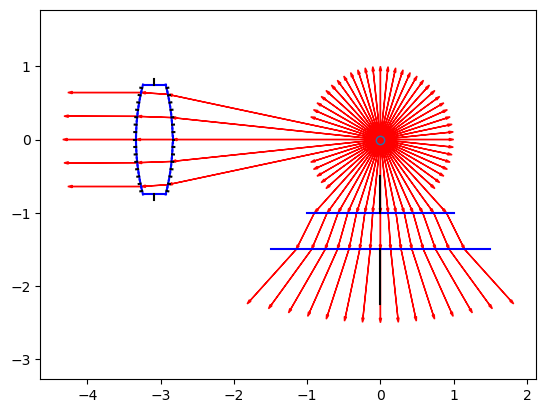

In [ ]:
#| hide

su = lens(R1, R2, T, H, XL, N=16)
for ss in su:
    surf.append(ss)

# Source Point
sp    = Point(0.0,0.0)

# Initial Rays
rays_out = gen_rays(sp, -180, 180, 60, endpoint=False)

rays_all = []

for k in range(5):
    rays_in = rays_out.copy()
    rays_out = []
    for r in rays_in:
        pc, sc = cast(r,surf)
        if pc != None:
            r.b = pc
            ref = refract(r,sc,pc)
            if ref != None:
                rays_out.append(ref)
        rays_all.append(r)
        #print('{k}: In {rin} Ref {ref}'.format(k=k, rin=r, ref=ref))
for r in rays_out:
    rays_all.append(r)


plot_scene(rays_all, surf, sp, raycol='red')


Ray caster should start at sp, array of cast rays added to list with initial intensity.

Every ray is intersected with every surface. Closest surface (in direction of ray) is chosen as first intersect. Intersect position noted as new source point, reflected and refracted rays generated. Intensity of each decreased. 

Rays removed with no intersections left or intensity too low.

## Fresnel Equations

In [ ]:
#| export

def reflectance(r, sc):
    dn = r.vec().norm().dot(sc.normal().norm())
    if dn < 0:
        ai = np.arccos(-dn)
        n1 = sc.n1
        n2 = sc.n2
    else:
        ai = np.arccos(dn)
        n1 = sc.n2
        n2 = sc.n1

    rs = ((n1*np.cos(ai) - n2*np.sqrt(1-(n1/n2*np.sin(ai))**2))/(n1*np.cos(ai) + n2*np.sqrt(1-(n1/n2*np.sin(ai))**2)))**2
    rp = ((-n2*np.cos(ai) + n1*np.sqrt(1-(n1/n2*np.sin(ai))**2))/(n2*np.cos(ai) + n1*np.sqrt(1-(n1/n2*np.sin(ai))**2)))**2
    re = 0.5*(rs+rp)
    #re[np.isnan(re)] = 1.0
    return re


In [ ]:
#| hide

# n1 = 1.0
# n2 = 1.5

# ai = np.linspace(0,90,1000, endpoint=False)*np.pi/180.0

# r = Point(-np.cos(ai), np.sin(ai))
# n = Point(0,1)
# ai = np.arccos(r.dot(n))

# sc = Surface(Point(0,0), Point(0,1))
# re = reflectance(r,sc)

# import matplotlib.pyplot as plt
# fig = plt.figure()
# # plt.plot(ai*180/np.pi, rs, '--b')
# #plt.plot(ai*180/np.pi, rp, '--r')
# plt.plot(ai*180/np.pi, re, '--k')

# #plt.xlim(0,90)
# plt.show(fig)

Now lets see all the reflect and refract work. 

In [ ]:
surf = []
surf.append(Surface(Point(4,2), Point(2,2), n2=1.5))
surf.append(Surface(Point(3,0), Point(4,2), n2=1.5))
surf.append(Surface(Point(2,2), Point(3,0), n2=1.5))


# Source Point
sp    = Point(0.0,1.0)

# Initial Rays
rays_out = gen_rays(sp, -10, 10, 5, endpoint=False)


In [ ]:
#| export
def raytrace(rays_out, surf, reflect_rays=True, refract_rays=True, DEPTH=10, RT=0.001, verbose=False):
  
    rays_all = []
    for k in range(DEPTH):
        rays_in = rays_out.copy()
        rays_out = []
        for r in rays_in:
            pc, sc = cast(r,surf)
            if pc != None:
                RI = reflectance(r, sc)
                r.b = pc
                if refract_rays:
                    ref = refract(r,sc,pc)
                    if ref != None:
                        ref.I = r.I*(1-RI)
                        if ref.I > RT:
                            rays_out.append(ref)
                    else:
                        RI = 1.0
                else:
                    RI = 1.0

                if reflect_rays:
                    ref = reflect(r,sc,pc)
                    ref.I = r.I*RI
                    if ref.I > RT:
                        rays_out.append(ref)
            rays_all.append(r)
            if verbose:
                print('{k}: In {rin} Ref {ref}'.format(k=k, rin=r, ref=ref))
    for r in rays_out:
        rays_all.append(r)
    
    return rays_all


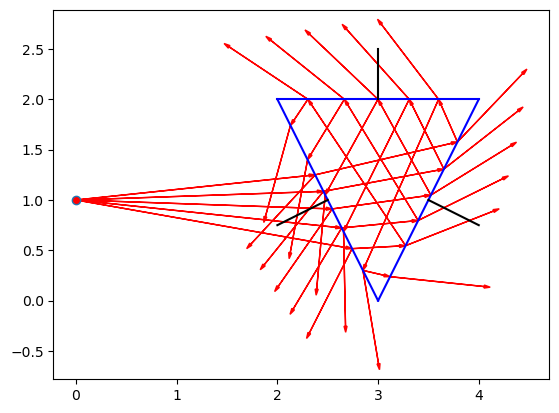

In [ ]:

rays_all = raytrace(rays_out, surf)
plot_scene(rays_all, surf, sp, raycol='red')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()